In [175]:
%pylab inline
pylab.rcParams['figure.figsize'] = 12,5

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [176]:
# This script will parse a CSV file taken from the Spectre Simulations and extract out the Early Voltage
import os
import sys
from scipy.optimize import leastsq
from pylab import *
import csv
import mpld3
from IPython.display import Image

This notebook will be used to extract various transistor properties from simulation, based on the All-Region MOSFET Model described in Schneider and Galup-Montoro's book.  As such, the parameters are with reference to how they are defined in his book.

# General functions

In [177]:
# This function reads a csv file and returns the raw data from the file,
# excluding the first line.  It will return the raw data as two lists: the first
# list will have the xVals, and the second array will have the yVals.
def readFile(filePath):
    data = genfromtxt(filePath, dtype=float, delimiter=",", skip_header=1)
    xVals = data[:,0::2]
    yVals = data[:,1::2]
    return xVals, yVals

# A function that allows the end-user to specify the type of plot he/she wants 
# to retrieve by various parameters.  Essentially, this is a wrapper on the 
# readFile function above.
def getData(folderRoot, FETType="NFET_eg1L", CurveType="IdsVgs", IDVal="_Vds0.1"):
    fN = folderRoot + FETType + "_" + CurveType + "_" + IDVal + ".csv"
    xVals, yVals = readFile(fN)
    return xVals, yVals

# fitLine takes data organized as columns of x,y pairs of data, and sorts through the columns to fit a line to each
# column's worth of data.  It returns an array for each output variable, m and b.  Each output array is of length = 
# number of columns
def fitLine(data):
    Xs, Ys = data
    ms = list()
    bs = list()
    numCols = shape(Ys)[1]
    for i in range(numCols):
        popt,pcov = leastsq(linFitErr, (0.00002, 0.00005), args=(Xs, Ys.T[i]))
        #print popt
        ms.append(popt[0])
        bs.append(popt[1])
    return array(ms), array(bs)

# getEarlyVoltages finds the slope and y-intercept of the line that best fits the data
# for x-values above "threshold"
def getEarlyVoltages(origVds, origIds, threshold):
    mask = origVds>threshold
    if len(mask)<1:
        print "WARNING: Threshold might be set too high"
    ev_Vds = origVds[mask]
    ev_Ids = origIds[mask]
    
    Ms, Bs = fitLine((ev_Vds,ev_Ids))
    EarlyVoltages = calcEV(Ms, Bs)
    print "Early Voltages:\t", EarlyVoltages
    
    return (ev_Vds, ev_Ids, EarlyVoltages, Ms, Bs)

# calcEV takes the slope and y-intercept of a line and uses that to calculate the x-intercept.
# This allows the user to fit a linear line and calculate the Early Voltage from that.
def calcEV(m, b):
    return -b/m

# UT calculates the thermal voltage as a function of temperature (in Celsius), the value of
# electronic charge, and Boltzmann's constant.
def UT(degC):
    _k = 1.3806503e-23
    _q = 1.60217646e-19
    return(_k*(273.15+degC)/_q)

## Functions to be used for fitting algorithms

In [178]:
# linFit gets plots a line with slope m, and y-intercept b
def linFit(x, m, b):
    return m*x + b

# linFitErr calculates the difference between some data and a theoretical line with slope m, and
# y-intercept b.
def linFitErr(x0s, xData, yData):
    (m,b) = x0s
    return yData - linFit(xData, m, b)

In [186]:
def compareFETs(FETTypes, folderRoots, ttl, curveType="IdsVgsCurve"):
    FETType1, FETType2 = FETTypes
    folderRoot1, folderRoot2 = folderRoots
    
    numTemps = len(temps)
    maxY = 0
    
    Vths1 = list()
    ISs1 = list()
    Vths2 = list()
    ISs2 = list()
    
    for i, curTemp in enumerate(temps):
        Vd = Vds[i]
        #print 
        print "Temp:", curTemp, "\tVds:", Vd

        origVgs1, origVgsIds1 = getData(folderRoot1, FETType=FETType1,
                                                CurveType=curveType, IDVal="Vds"+str(Vd))
        origVgs2, origVgsIds2 = getData(folderRoot2, FETType=FETType2,
                                                CurveType=curveType, IDVal="Vds"+str(Vd))

        Vth1, IS1, gms1, gmOverId1 = plotVgPlots(origVgs1[:,i], origVgsIds1[:,i],
                                        ttl=ttl, color=(1.*i/(numTemps-1), 0, 1-(1.*i/(numTemps-1))))
        #print "Vth1:\t", Vth1, "\nIS1:\t", IS1
        Vths1.append(Vth1)
        ISs1.append(IS1)    

        Vth2, IS2, gms2, gmOverId2 = plotVgPlots(origVgs2[:,i], origVgsIds2[:,i],
                                        ttl=ttl, color=(1.*i/(numTemps-1), 0.5, 1-(1.*i/(numTemps-1))))
        #print "Vth2:\t", Vth2, "\nIS2:\t", IS2
        Vths2.append(Vth2)
        ISs2.append(IS2)

        maxY = max( [maxY, 1.1*max( gmOverId1.flatten() ), 1.1*max( gmOverId2.flatten() )] )
        #print "Max Y:", maxY
        ylim((0,maxY))
        
    print "Vth (",FETType1,"):", Vths1, "\nVth (",FETType2,"):", Vths2
    print "IS (",FETType1,"):", ISs1, "\nIS (",FETType2,"):",ISs2
    
    return Vths1, ISs1, Vths2, ISs2

## Plotting functions

In [180]:
fntSz = 16
def plotIds(data, ttl="", xlbl="", ylbl="$I_d (A)$", color=(1,0,0)):
    Xs, Ys = data
    # Determine whether or not there are multiple columns worth of (x,y) plots.
    # If so, color code the plots from blue to red, otherwise, use the input color
    if len(shape(Ys))<=1:
        plot(Xs, Ys, '.', color=color)
    else:
        numCols = shape(Ys)[1]
        for i in range(numCols):
            plot(Xs, Ys.T[i], '.', color=(1.*i/(numCols-1), 0, 1.-(1.*i/(numCols-1))))
        
    xlabel(xlbl, fontsize=fntSz)
    ylabel(ylbl, fontsize=fntSz)
    ylim([0,Ys.max()*1.1])
    title(ttl)

def plotlogIds(data, ttl="", xlbl="", ylbl="$I_d (A)$", color=(1,0,0)):
    Xs, Ys = data
    # Determine whether or not there are multiple columns worth of (x,y) plots.
    # If so, color code the plots from blue to red, otherwise, use the input color
    if len(shape(Ys))<=1:
        semilogy(Xs, Ys, '.', color=color)
    else:
        numCols = shape(Ys)[1]
        for i in range(numCols):
            semilogy(Xs, Ys.T[i], '.', color=(1.*i/(numCols-1), 0, 1.-(1.*i/(numCols-1))))
            
    xlabel(xlbl, fontsize=fntSz)
    ylabel(ylbl, fontsize=fntSz)
    ylim([Ys.min()/10, Ys.max()*10])
    title(ttl)

def plotKappa(data, temp=25, ttl=""):
    Xs, Ys = data
    numCols = shape(Ys)[1]
    for i in range(numCols):
        dYs = diff(log(Ys.T[i]))*UT(temp)
        dXs = diff(Xs)
        plot(Xs[1:], dYs/dXs, '.', color=(1.*i/numCols, 0, 0))
    xlabel(r'$V_{gs}$', fontsize=fntSz)
    ylabel(r'$\kappa$', fontsize=fntSz)
    #ylim([Ys.min()/10, Ys.max()*10])
    title(ttl)
    
def plotEarlyVTheory(Vds, Ms, Bs, minX=-30.):
    #print "Slopes: ", Ms
    #print "Intercepts: ", Bs
    for i in range(len(Ms)):
        thIds = linFit(Vds, Ms[i], Bs[i])
        plot(Vds, thIds, "b.")
        thLineXs = arange(minX, max(Vds), 0.01)
        thIdLine = linFit(thLineXs, Ms[i], Bs[i])
        plot(thLineXs, thIdLine, "b--")
    xlims = [minX*1.05, max(Vds)]
    ylims = [0, max(thIdLine)*1.1]
    xlim(xlims)
    ylim(ylims)

In [181]:
def plotVgPlots(origVgs, origVgsIds, ttl, color=(1,0,0)):
    gms = abs(diff(origVgsIds, axis=0))/diff(origVgs, axis=0)
    gmOverId = gms/origVgsIds[:-1]
    
    # Calculate the threshold voltage from the last plot's data
    half_gmToIdRatio = gmOverId.max(axis=0)*0.53  #from S&GM, p.462, footnote 1
    #print "Half of max(gm/Id ratio):", half_gmToIdRatio
    
    #for i, curHalfPt in enumerate(half_gmToIdRatio):
    if gmOverId[0]>gmOverId[-1]:   # FETType is an NFET
        Vth = origVgs[where(gmOverId>=half_gmToIdRatio)][-1]
    else:    # FETType is a PFET FETType=="P"
        Vth = origVgs[where(gmOverId>=half_gmToIdRatio)][0]
    #print "Vth: ", Vth
    
    Vth_idx = where(origVgs[:]==Vth)
    ISVal = origVgsIds[Vth_idx][0]*1.13 # from S&GM, p.462, Footnote 1
    #print "IS Val: ", ISVal

    subplot(1,3,1)
    plotlogIds((origVgs, origVgsIds), ttl=ttl, xlbl=r'$V_{gs}$', color=color)
    # Use the threshold voltage calculated to plot a vertical line in the plot
    vlines(Vth, origVgsIds.min()/10, origVgsIds.max()*10,
           colors=color,
           linestyles='dashed')

    subplot(1,3,2)
    plotlogIds((origVgs[:-1], gms), 
               ttl=ttl, xlbl=r'$V_{gs}$', ylbl=r'$g_m$', color=color)
    
    subplot(1,3,3)
    plotIds((origVgs[:-1], gmOverId), 
               ttl=ttl, xlbl=r'$V_{gs}$', ylbl=r'$g_m/I_{ds}$', color=color)
    # Use the threshold voltage calculated to plot a vertical line in the plot
    hlines(half_gmToIdRatio, 0, 1,
           colors=color,
           linestyles='dashed')
    vlines(Vth, gmOverId.min()/10, gmOverId.max()*10,
           colors=color,
           linestyles='dashed')

    tight_layout()

    return Vth, ISVal, gms, gmOverId

# Get general data from the files

In [182]:
folderRoot = "/home/noza/work/Braindrop/CDB/BDTests/NFET_test/IV_Sim_Results/ParamExtract/"
folderRoot_P = "/home/noza/work/Braindrop/CDB/BDTests/PFET_test/IV_Sim_Results/ExtractParams/"

#paramFileName = folderRoot + "ParamAnalysisVals_VgSweep.csv"
#with open(paramFileName) as pfn:
#    reader = csv.reader(pfn)
#    data = list()
#    for i, row in enumerate(reader):
#        data.append(double(row[1:]))
#Vgs = data[0]
#print "Vg Vals:", Vgs
paramFileName = folderRoot + "ParamAnalysisVals_ohmicVdsTempSweep_IdVgsPlot.csv"
with open(paramFileName) as pfn:
    reader = csv.reader(pfn)
    data = list()
    for i, row in enumerate(reader):
        data.append(double(row[1:]))
print data
Vds = data[0]
print "Vd Vals:", Vds
if len(data)>1:
    temps = data[1]
    print "Temp Vals:", temps

[array([ 0.012,  0.013,  0.014]), array([  0.,  25.,  50.])]
Vd Vals: [ 0.012  0.013  0.014]
Temp Vals: [  0.  25.  50.]


# Extract Parameters

## Plot $I_{ds}$ vs $V_{ds}$

In [ ]:
figsize(12,10)
subplot(2,2,1)
plotIds((origVds_1L, origIds_1L_Vds*1e6),
        ttl="Thin-FET, 1L, Varying $V_{gs}$", xlbl=r'$V_{ds}$', ylbl=r'$I_d (\mu A)$')
subplot(2,2,2)
plotIds((origVds_3L, origIds_3L_Vds*1e6),
        ttl="Thin-FET, 3L, Varying $V_{gs}$", xlbl=r'$V_{ds}$', ylbl=r'$I_d (\mu A)$')
subplot(2,2,3)
plotIds((origVds_eg1L, origIds_eg1L_Vds*1e6),
        ttl="Thick-FET, 1L, Varying $V_{gs}$", xlbl=r'$V_{ds}$', ylbl=r'$I_d (\mu A)$')
subplot(2,2,4)
plotIds((origVds_eg3L, origIds_eg3L_Vds*1e6),
        ttl="Thick-FET, 3L, Varying $V_{gs}$", xlbl=r'$V_{ds}$', ylbl=r'$I_d (\mu A)$')
tight_layout()
show()

## Plot $I_{ds}$, $g_m$, and $\frac{g_m}{I_{ds}}$ vs $V_{gs}$
From the transconductance-to-current plot, we'll be able to extract $I_S$ and $V_T$

### Thick Oxide

Temp: 0.0 	Vds: 0.012
Temp: 25.0 	Vds: 0.013
Temp: 50.0 	Vds: 0.014
Vth ( NFET_eg1L ): [0.65300000000000047, 0.64100000000000046, 0.62600000000000044] 
Vth ( PFET_eg1L ): [0.31200000000000022, 0.33400000000000019, 0.35600000000000032]
IS ( NFET_eg1L ): [1.2139880527590557e-07, 1.3843537536339645e-07, 1.4828965266114836e-07] 
IS ( PFET_eg1L ): [3.1025118039306649e-08, 3.4684252478598241e-08, 3.7997837752102026e-08]


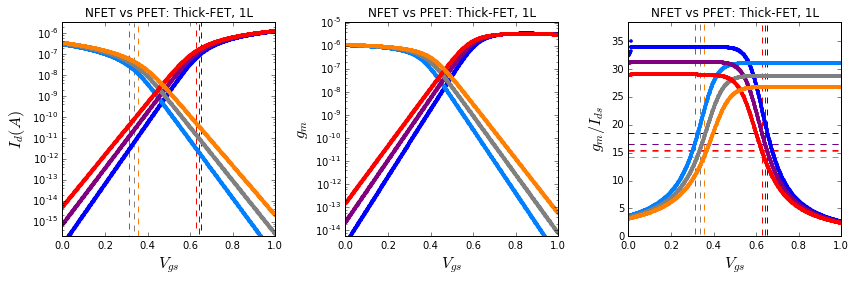

In [77]:
figsize(12,4)
Vths_N_eg1L, IS_N_eg1L, Vths_P_eg1L, IS_P_eg1L = compareFETs(("NFET_eg1L", "PFET_eg1L"), 
            (folderRoot, folderRoot_P),
            "NFET vs PFET: Thick-FET, 1L",
            curveType="IdsVgsCurve")

#### Long Channel (1L, 450nm)

Temp: 0.0 	Vds: 0.012
Temp: 25.0 	Vds: 0.013
Temp: 50.0 	Vds: 0.014
Vth ( NFET_eg3L ): [0.65800000000000047, 0.64700000000000046, 0.63100000000000045] 
Vth ( PFET_eg3L ): [0.30500000000000022, 0.32900000000000018, 0.35200000000000031]
IS ( NFET_eg3L ): [4.5339835562226938e-08, 5.3500456931882252e-08, 5.6736093139150413e-08] 
IS ( PFET_eg3L ): [9.1178580362113206e-09, 9.9626453726181503e-09, 1.086840943541093e-08]


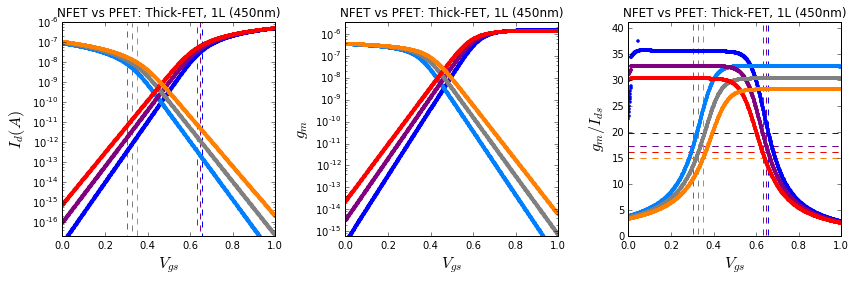

In [183]:
figsize(12,4)
Vths_N_eg1L, IS_N_eg1L, Vths_P_eg1L, IS_P_eg1L = compareFETs(("NFET_eg3L", "PFET_eg3L"), 
            (folderRoot, folderRoot_P),
            "NFET vs PFET: Thick-FET, 1L (450nm)",
            curveType="IdsVgsCurve")

### Thin-Oxide

Temp: 0.0 	Vds: 0.012
Temp: 25.0 	Vds: 0.013
Temp: 50.0 	Vds: 0.014
Vth ( NFET_1L ): [0.51400000000000035, 0.50800000000000034, 0.50100000000000033] 
Vth ( PFET_1L ): [0.35100000000000031, 0.37300000000000028, 0.4000000000000003]
IS ( NFET_1L ): [3.8723216464001473e-07, 4.4330817789349527e-07, 4.9835851290818388e-07] 
IS ( PFET_1L ): [1.1383008271093398e-07, 1.428885411127493e-07, 1.6428249810338002e-07]


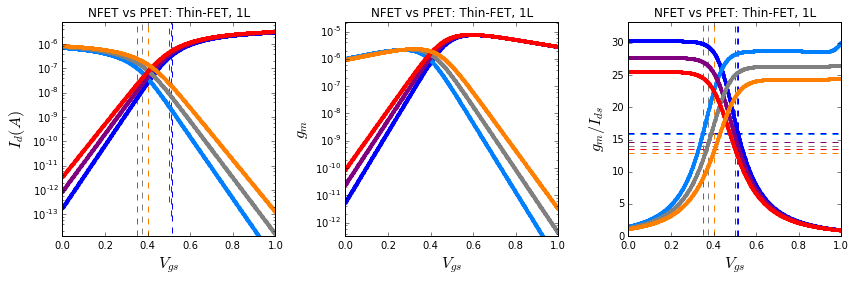

In [78]:
figsize(12,4)
Vths_N_1L, IS_N_1L, Vths_P_1L, IS_P_1L = compareFETs(("NFET_1L", "PFET_1L"), 
            (folderRoot, folderRoot_P),
            "NFET vs PFET: Thin-FET, 1L",
            curveType="IdsVgsCurve")

## Plot slope factor $n$ ($\frac{1}{\kappa}$)

In [189]:
def plotVpvsVg(data, ttl="", color=(1,0,0), fntSz=12):
    Xs, Ys = data
    
    # Determine whether or not there are multiple columns worth of (x,y) plots.
    # If so, color code the plots from blue to red, otherwise, use the input color
    if len(shape(Ys))<=1:
        #print "plotting only one dataset"
        plot(Xs, Ys, '-', color=color)
    else:
        #print "plotting multiple datasets"
        numCols = shape(Ys)[1]
        for i in range(numCols):
            plot(Xs, Ys.T[i], '-', color=(1.*i/(numCols-1), 0, 1.-(1.*i/(numCols-1))))
    #numCols = shape(Ys)[1]
    #for i in range(numCols):
    #    plot(Xs[1:], dYs/dXs, '.', color=color)
    xlabel(r'$V_{g}$', fontsize=fntSz)
    ylabel(r'$V_{p} (V_s)$', fontsize=fntSz)
    #ylim([Ys.min()/10, Ys.max()*10])
    title(ttl)
    
def plotSlopeFactor(data, ttl="", color=(1,0,0), fntSz=12):
    Xs, Ys = data
    dYs = diff(Ys)
    dXs = diff(Xs)
    plot(Xs[:-1], dXs/dYs, '.', color=color)
    xlabel(r'$V_{g}$', fontsize=fntSz)
    ylabel(r'$n (1/\kappa)$', fontsize=fntSz)
    #ylim([Ys.min()/10, Ys.max()*10])
    title(ttl)
    return dXs/dYs

In [214]:
def slopeFactor(folderRoot, FETType="NFET", curveType="VgvsVs_KappaExtraction", temps=[25], xLims=(0,1)):
    numTemps = len(temps)
    SFs = list()
    for i, curTemp in enumerate(temps):
        #print
        print "Temp:", curTemp

        origVps1, origVgs1 = getData(folderRoot, FETType=FETType,
                                        CurveType=curveType, IDVal="T"+str(int(curTemp))+"C")
        subplot(1,2,1)
        for j in arange(shape(origVgs1)[1]-1):
            plotVpvsVg((origVgs1[:,j+1], origVgs1[:,0]), ttl="$V_p vs V_g$: "+str(FETType),
                       color=(1.*i/(numTemps-1), 1.*j/(numTemps-1), 1-(1.*i/(numTemps-1))), fntSz=14)
        xlim(xLims)

        origVps2, origVgs2 = getData(folderRoot, FETType=FETType,
                                        CurveType=curveType, IDVal="T"+str(int(curTemp))+"C")
        #print origVgs2
        subplot(1,2,2)
        curSFs = list()
        for j in arange(shape(origVgs1)[1]-1):
            tmpSFs = plotSlopeFactor((origVgs2[:,j+1], origVgs2[:,0]), ttl="Slope Factor ($n$): "+str(FETType),
                       color=(1.*i/(numTemps-1), 1.*j/(numTemps-1), 1-(1.*i/(numTemps-1))), fntSz=14)
            curSFs.append(array(tmpSFs))
        xlim(xLims)
        #print array(curSFs)
        SFs.append(array(curSFs))
        print "Mean SFs:", mean(array(curSFs), axis=1), "\tMean kappa:", mean(1/array(curSFs), axis=1)
        print "Min SFs:", array(curSFs).min(axis=1), "\tMin kappa:", 1/array(curSFs).min(axis=1)
        print "Max SFs:", array(curSFs).max(axis=1), "\tMax kappa:", 1/array(curSFs).max(axis=1)

    tight_layout()
    # Returns the average slope factor value
    return array(SFs)

_Note: the mean, min, and max values shown are for the full measured range of values and not for the region that is being viewed using xLims()_

Temp: 0.0
Mean SFs: [ 1.05144485  1.11082098] 	Mean kappa: [ 0.95107236  0.90023955]
Min SFs: [ 1.05071929  1.10778706] 	Min kappa: [ 0.95172898  0.90270056]
Max SFs: [ 1.05202019  1.11589681] 	Max kappa: [ 0.9505521   0.89614021]
Temp: 25.0
Mean SFs: [ 1.0515543   1.11142043] 	Mean kappa: [ 0.95097336  0.89975473]
Min SFs: [ 1.05081392  1.10819127] 	Min kappa: [ 0.95164328  0.90237131]
Max SFs: [ 1.0521407   1.11696568] 	Max kappa: [ 0.95044323  0.89528265]
Temp: 50.0
Mean SFs: [ 1.0516902   1.11204012] 	Mean kappa: [ 0.95085048  0.89925401]
Min SFs: [ 1.05066554  1.10864372] 	Min kappa: [ 0.95177767  0.90200304]
Max SFs: [ 1.05228132  1.1180061 ] 	Max kappa: [ 0.95031621  0.8944495 ]


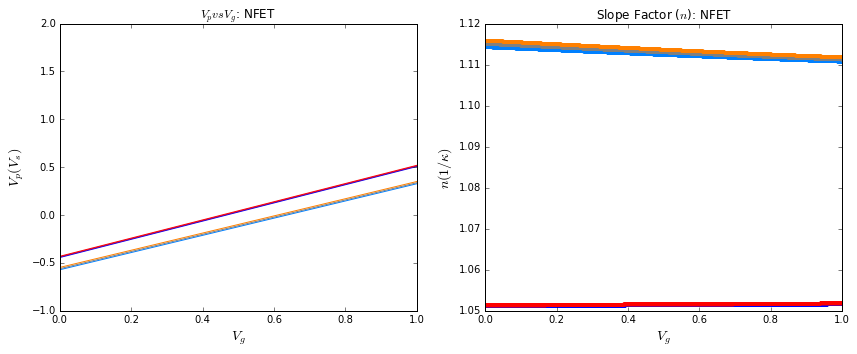

Temp: 0.0
Mean SFs: [ 1.06284007  1.12089476] 	Mean kappa: [ 0.94087543  0.89214449]
Min SFs: [ 1.06248354  1.1205887 ] 	Min kappa: [ 0.94119105  0.89238808]
Max SFs: [ 1.06361993  1.12189485] 	Max kappa: [ 0.94018547  0.89134913]
Temp: 25.0
Mean SFs: [ 1.06318807  1.12099941] 	Mean kappa: [ 0.94056747  0.89206122]
Min SFs: [ 1.06283244  1.12066301] 	Min kappa: [ 0.94088208  0.89232891]
Max SFs: [ 1.06398571  1.12209516] 	Max kappa: [ 0.93986225  0.89119001]
Temp: 50.0
Mean SFs: [ 1.06362303  1.1211343 ] 	Mean kappa: [ 0.94018283  0.89195391]
Min SFs: [ 1.06328066  1.12076749] 	Min kappa: [ 0.94048546  0.89224572]
Max SFs: [ 1.06440983  1.1223325 ] 	Max kappa: [ 0.93948775  0.89100155]


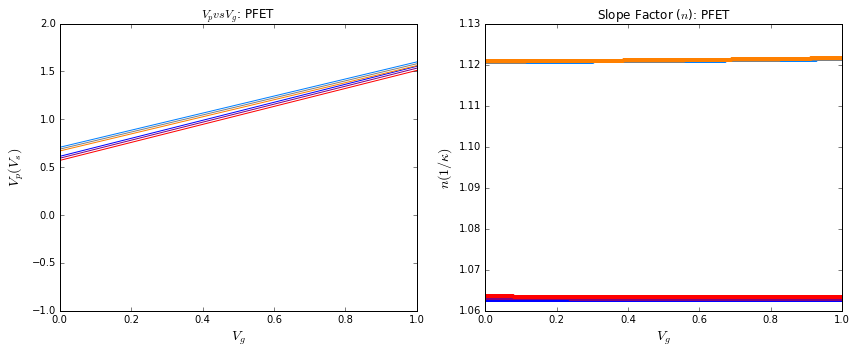

In [215]:
figsize(12,5)
SFs = slopeFactor(folderRoot, FETType="NFET", curveType="VgvsVs_KappaExtraction", temps=temps, xLims=(0,1))
show()
SFs = slopeFactor(folderRoot_P, FETType="PFET", curveType="VgvsVs_KappaExtraction", temps=temps, xLims=(0,1))

Temp: 0.0
Mean SFs: [ 1.1097211] 	Mean kappa: [ 0.9011279]
Min SFs: [ 1.10888761] 	Min kappa: [ 0.90180465]
Max SFs: [ 1.11189435] 	Max kappa: [ 0.89936602]
Temp: 25.0
Mean SFs: [ 1.1102739] 	Mean kappa: [ 0.90067937]
Min SFs: [ 1.10935567] 	Min kappa: [ 0.90142416]
Max SFs: [ 1.11268402] 	Max kappa: [ 0.89872774]
Temp: 50.0
Mean SFs: [ 1.11081805] 	Mean kappa: [ 0.90023828]
Min SFs: [ 1.1060272] 	Min kappa: [ 0.9041369]
Max SFs: [ 1.11343019] 	Max kappa: [ 0.89812546]


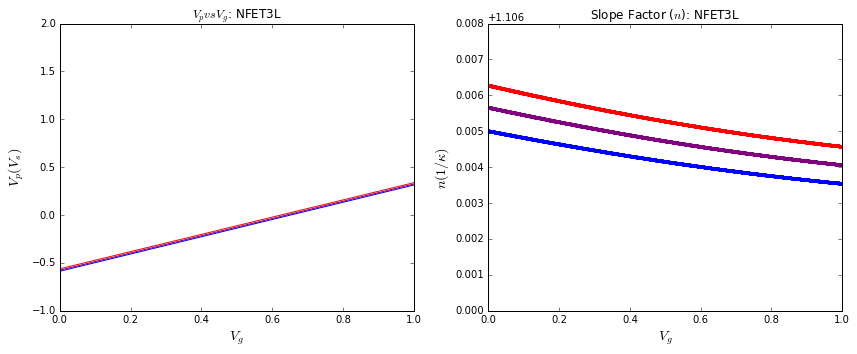

Temp: 0.0
Mean SFs: [ 1.12370931] 	Mean kappa: [ 0.88990996]
Min SFs: [ 1.12336076] 	Min kappa: [ 0.89018598]
Max SFs: [ 1.12487435] 	Max kappa: [ 0.88898818]
Temp: 25.0
Mean SFs: [ 1.12380197] 	Mean kappa: [ 0.88983662]
Min SFs: [ 1.12341987] 	Min kappa: [ 0.89013914]
Max SFs: [ 1.12508456] 	Max kappa: [ 0.88882208]
Temp: 50.0
Mean SFs: [ 1.12390856] 	Mean kappa: [ 0.88975225]
Min SFs: [ 1.12349101] 	Min kappa: [ 0.89008278]
Max SFs: [ 1.12531692] 	Max kappa: [ 0.88863855]


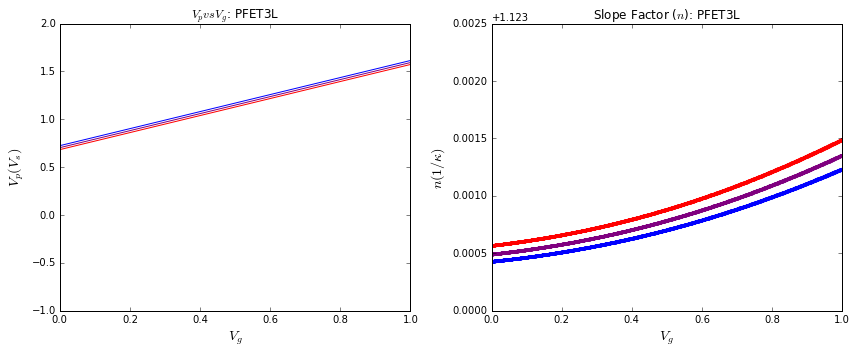

In [216]:
figsize(12,5)
SFs = slopeFactor(folderRoot, FETType="NFET3L", curveType="VgvsVs_KappaExtraction", temps=temps, xLims=(0,1))
show()
SFs = slopeFactor(folderRoot_P, FETType="PFET3L", curveType="VgvsVs_KappaExtraction", temps=temps, xLims=(0,1))

## Find and Plot the Early Voltages

In [ ]:
threshold = 0.6

figsize(12,10)
subplot(2,2,1)
ev_Vds, ev_Ids, EarlyVoltages, Ms, Bs = getEarlyVoltages(origVds_1L, origIds_1L_Vds, threshold)
plotIds((origVds_1L, origIds_1L_Vds), ttl="Thin-FET, 1L, Varying $V_{gs}$", xlbl='$V_{ds}$')
plotEarlyVTheory(ev_Vds, Ms, Bs, -4)

subplot(2,2,2)
ev_Vds, ev_Ids, EarlyVoltages, Ms, Bs = getEarlyVoltages(origVds_3L, origIds_3L_Vds, threshold)
plotIds((origVds_3L, origIds_3L_Vds), ttl="Thin-FET, 3L, Varying $V_{gs}$", xlbl='$V_{ds}$')
plotEarlyVTheory(ev_Vds, Ms, Bs, -6)

subplot(2,2,3)
ev_Vds, ev_Ids, EarlyVoltages, Ms, Bs = getEarlyVoltages(origVds_eg1L, origIds_eg1L_Vds, threshold)
plotIds((origVds_eg1L, origIds_eg1L_Vds), ttl="Thick-FET, 1L, Varying $V_{gs}$", xlbl='$V_{ds}$')
plotEarlyVTheory(ev_Vds, Ms, Bs, -10)

subplot(2,2,4)
ev_Vds, ev_Ids, EarlyVoltages, Ms, Bs = getEarlyVoltages(origVds_eg3L, origIds_eg3L_Vds, threshold)
plotIds((origVds_eg3L, origIds_eg3L_Vds), ttl="Thick-FET, 3L, Varying $V_{gs}$", xlbl='$V_{ds}$')
plotEarlyVTheory(ev_Vds, Ms, Bs, -16)

tight_layout()
show()

# Appendix

## Fit the subthreshold region for parameters

In [ ]:
temp = 25
print Vds
print xData
print yData

popt, pcov = leastsq(Ids_NFET_Err, (0.7, 0.6, -9, 0.05), args=(xData, yData, Vds, temp))
kappa = popt[0]
gam = popt[1]
Kd = popt[2]
lamda = popt[3]